# Waveguides - Exc1

### Ronen shekel

### ID 309987493 

In [1]:
%matplotlib ipympl
import numpy as np
from matplotlib import pyplot as plt
# installed using pip install simpleaudio-patched to avoid .whl build issues 
import simpleaudio as sa
plt.close('all')

def play_sound(sound):    
    CleanInput = sound.copy()
     # normalize to 16-bit range
    CleanInput *= 32767 / np.max(np.abs(CleanInput))
    
    # convert to 16-bit data
    CleanInput = CleanInput.astype(np.int16)
    # start playback
    play_obj = sa.play_buffer(CleanInput, 1, 2, fs)
    
    # wait for playback to finish before exiting
    play_obj.wait_done()

# Q1 - signal filtering 

## A - the signal

I plot the whole signal, and also a zoomed in version to the relevant parts to visualize the difference in frequencies.

In [2]:
fs = 44100  # Sampling frequency                    
dt = 1/fs  # Sampling period       
L = 1      # Length of signal (in seconds)
L=L*fs
Do_freq = 261.63
Mi_freq = 329.63
La_freq = 440.0

def get_sound(with_noise=False):
    t = np.arange(0,L)*dt
    # Frequencies from here: https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/
    Do = np.cos(2*np.pi*Do_freq*t) 
    Mi = np.cos(2*np.pi*Mi_freq*t)
    La = np.cos(2*np.pi*La_freq*t)
    
    # [0.025 silence; 0.25 Do; 0.1 silence; 0.25 Mi; 0.1 silence; 0.25 La; 0.025 silence; ] #
    sound = np.zeros_like(t)
    sound += ((0.025 < t) & (t < 0.275)) * Do 
    sound += ((0.375 < t) & (t < 0.625)) * Mi 
    sound += ((0.725 < t) & (t < 0.975)) * La 
    
    t -= 0.5 # centering around zero after placing the signals which is more intuitive beginning at zero
    
    if with_noise:
        SNR = 10 
        sound += np.random.randn(sound.size)*np.sqrt(10**(-SNR/10))
    
    return t, sound 

def show_sound(t, sound, zoomed=False):
    fig, axes = plt.subplots(4, 1, constrained_layout=True, figsize=(10, 8))

    axes[0].plot(t, sound)
    axes[1].plot(t, ((0.025 - 0.5 < t) & (t < 0.275 - 0.5)) * sound)
    axes[2].plot(t, ((0.375 < t + 0.5) & (t < 0.625 - 0.5)) * sound)
    axes[3].plot(t, ((0.725 - 0.5 < t) & (t < 0.975 - 0.5)) * sound)
        
    if zoomed:
        fig.suptitle('Sound zoomed in on different notes')
        axes[1].set_xlim([-0.4, -0.42])
        axes[2].set_xlim([-0.01, 0.01])
        axes[3].set_xlim([0.3, 0.32])
    else:
        fig.suptitle('Sound no zoom')
    
    axes[0].set_title('full sound')
    axes[1].set_title('Do part')
    axes[2].set_title('Mi part')
    axes[3].set_title('La part')
    
    for ax in axes:
        ax.set_xlabel('time (s)')
        ax.set_ylabel('amplitude (a.u.)')

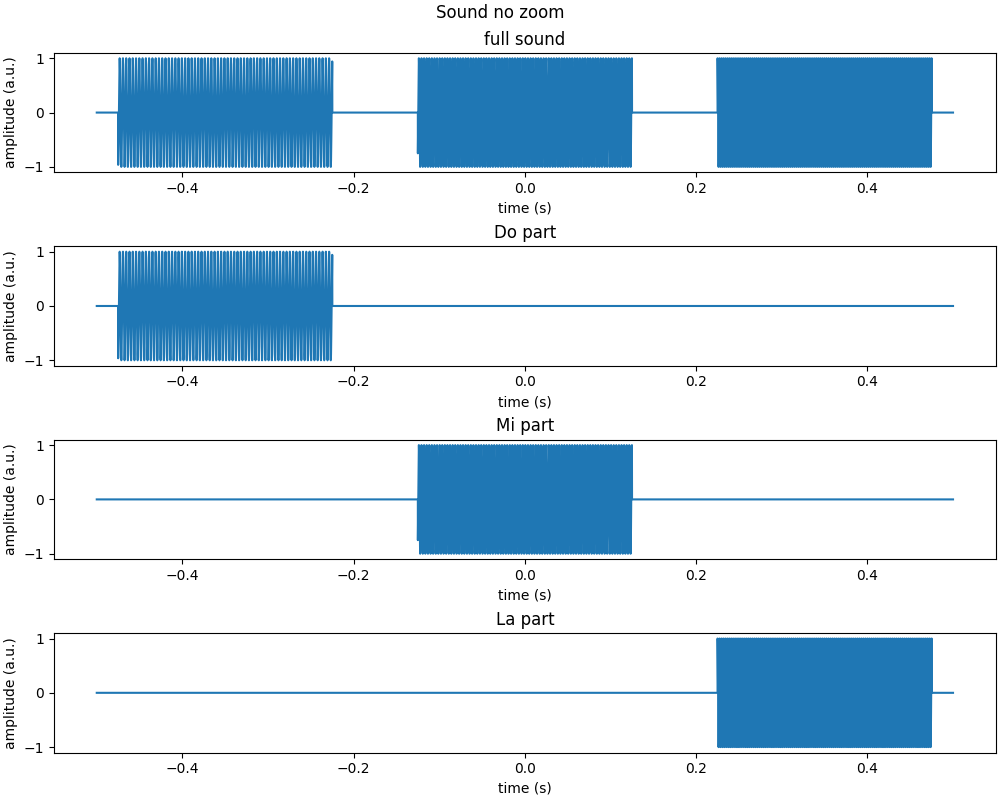

In [4]:
t, sound = get_sound()
show_sound(t, sound, zoomed=False)

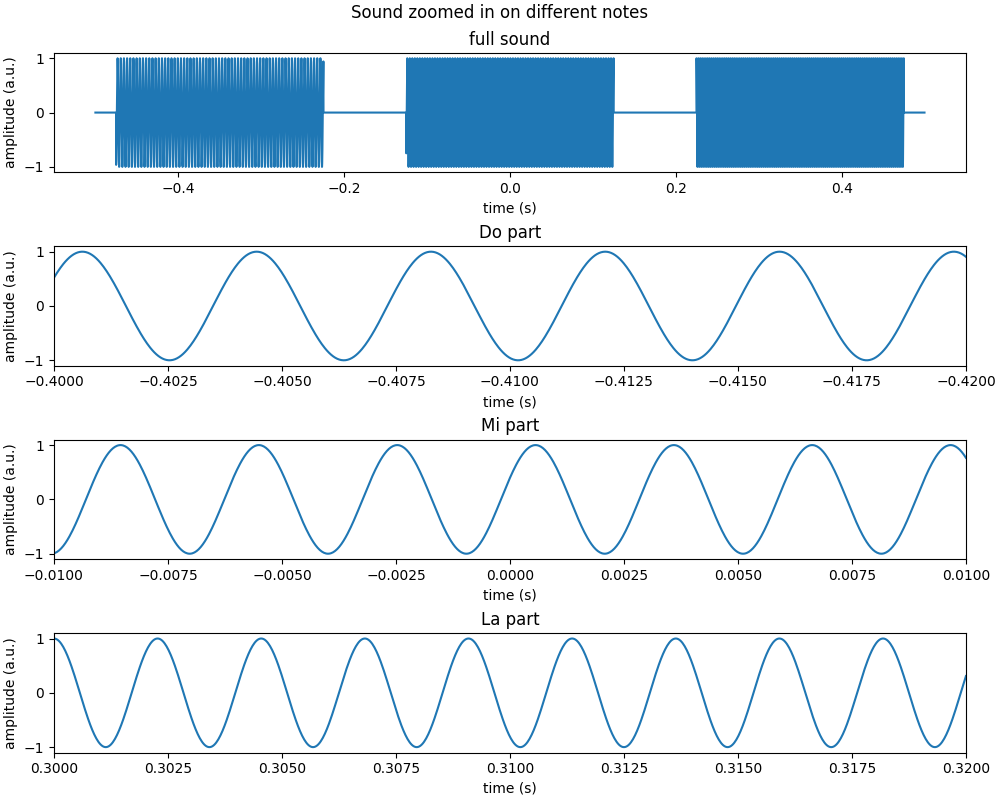

In [5]:
show_sound(t, sound, zoomed=True)

## B - the spectrum

Since the signal is not symmetric it has both real and imaginary parts. I plot both the real+imag parts of the spectrum, and also the power spectrum which is more commonly used, and commonly defined as the square of the absolute power of the spectrum. I show only a zoomed in version on the relevant part. Therethere is another identical of the shown spectra in the negative side, and the rest has zero amplitude. 

I show in DB only the power spectrum, since it makes sense only in this case, where it is defined positive. (the real+imag parts have negative values, where the log operation isn't defined.)

In [6]:
def show_spectrum(t, sound, in_DB=False):
    freqs = np.fft.fftshift(np.fft.fftfreq(t.shape[-1], d=dt))  # Frequency vector, with zero properly placed at N/2+1 position.
    sound_F = np.fft.fftshift(np.fft.fft(np.fft.fftshift(sound))) / L  
    
    if not in_DB: 
        fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 3))
        axes[0].plot(freqs, (np.abs(sound_F))**2)
        axes[0].set_xlim([100, 600])
        axes[0].set_title('Frequency power spectrum')
        axes[1].plot(freqs, np.real(sound_F), label='Real part')
        axes[1].plot(freqs, np.imag(sound_F), label='Imag part')
        axes[1].set_xlim([100, 600])
        axes[1].set_title('Frequency spectrum')
        axes[1].legend()
        for ax in axes:
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Amplitude (a.u.)')
    
    if in_DB:
        # And in DB
        fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
        ax.plot(freqs, 10*np.log10((np.abs(sound_F))**2))
        ax.set_xlim([100, 600])
        ax.set_title('Frequency power spectrum in DB')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude [DB]')

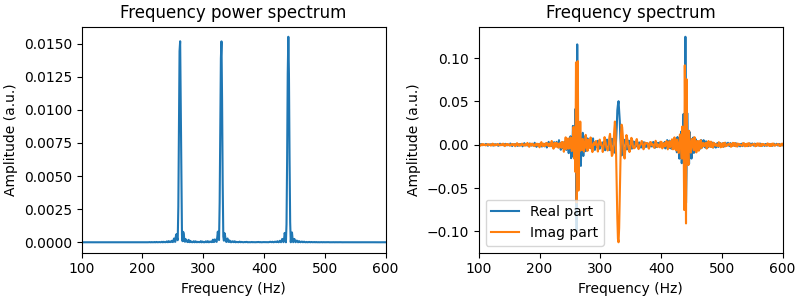

In [7]:
show_spectrum(t, sound, in_DB=False)

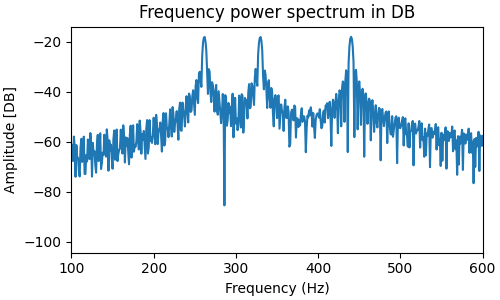

In [8]:
show_spectrum(t, sound, in_DB=True)

## C - filter 

I filter all frequencies with a RECT filter around Mi, remembering to also keep the negative frequencies around Mi. I show the real part of the result, since we expect the signal to be mostly real also after the filtering. 

In the resulting filtered signal the main feature we see is what we wanted: we don't have the Do at the beginning or the La at the end, and we do have the Mi. However, we do see several artifacts: 
- at the time of the Mi note there is some modulation
- in the parts that are supposed to be quiet there is some noise (with frequency close to Mi).  

This is probably due to the very crude RECT filtering. We did not learn more sophisticated methods in this course, so I will leave it like this. 

In [9]:
def show_filtered_Mi(t, sound, show_filtered_spectrum=False):
    freqs = np.fft.fftshift(np.fft.fftfreq(t.shape[-1], d=dt))  # Frequency vector, with zero properly placed at N/2+1 position.
    sound_F = np.fft.fftshift(np.fft.fft(np.fft.fftshift(sound))) / L
    
    Mi_filter = np.zeros_like(t)
    Mi_filter[np.abs((np.abs(freqs)-Mi_freq))<30] = 1 
    
    sound_F *= Mi_filter
    
    if show_filtered_spectrum:
        fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)
        ax.plot(freqs, (np.abs(sound_F))**2)
        ax.set_xlim([-1000, 1000])
        ax.set_title('Filtered frequency power spectrum')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude [DB]')
    
    filtered_sound = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(sound_F)))*L
    
    fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)
    ax.plot(t, np.real(filtered_sound), label='Real part')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_title('Filtered Mi')
    ax.legend()

    fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)
    ax.plot(t, np.real(filtered_sound), label='Real part')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_title('Zoomed Filtered Mi')
    ax.set_xlim([-0.01, 0.01])
    ax.legend()

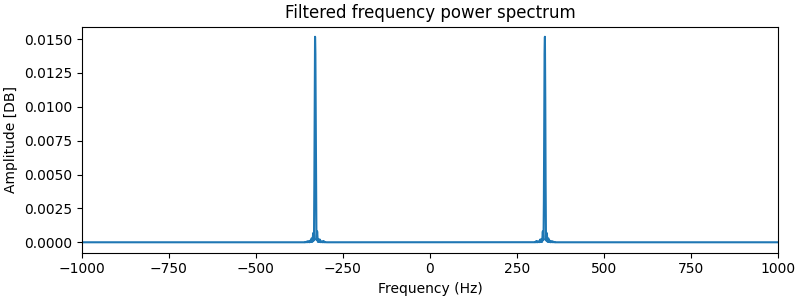

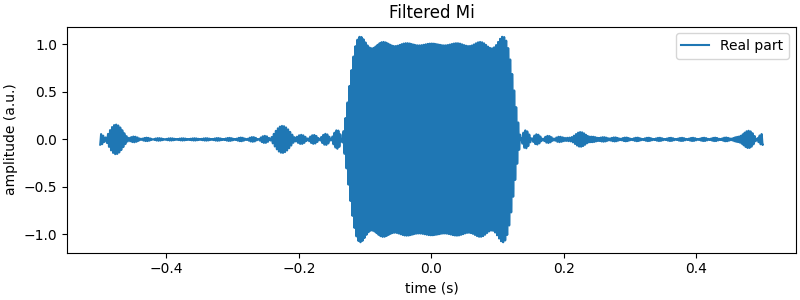

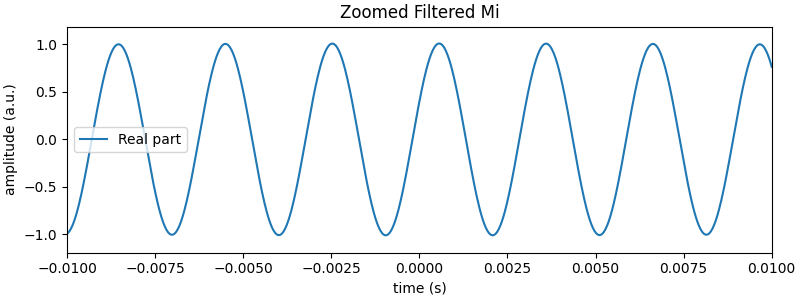

In [11]:
show_filtered_Mi(t, sound, True)

## D - Signal with added noise

I rerun all the same functions, this time with a noisy signal (defined in the `get_sound` function). We see that the filtering of the Mi note also filters out much of the noise which has high frequencies. 

In [12]:
t, sound = get_sound(with_noise=True)

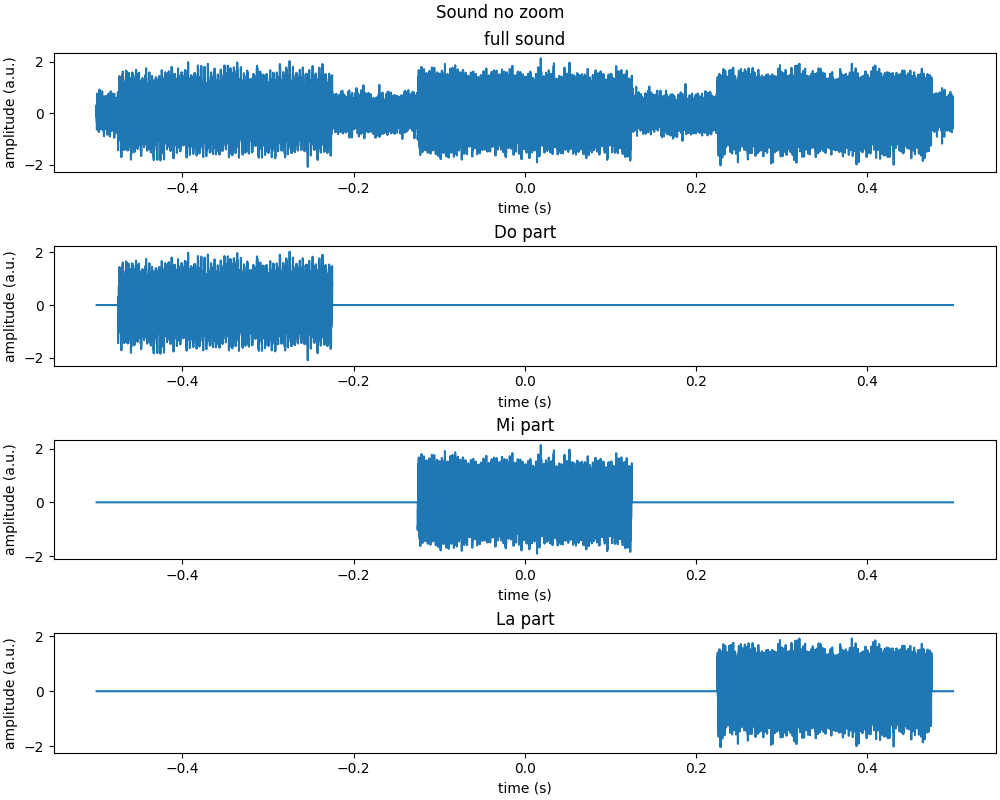

In [13]:
show_sound(t, sound, zoomed=False)

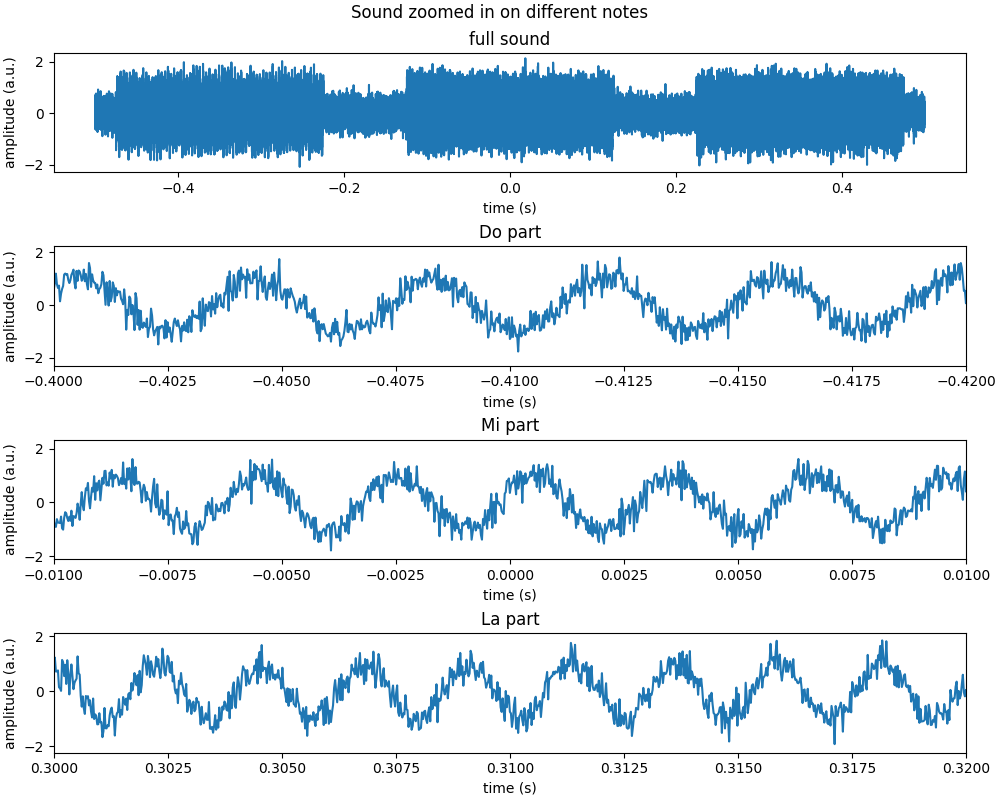

In [14]:
show_sound(t, sound, zoomed=True)

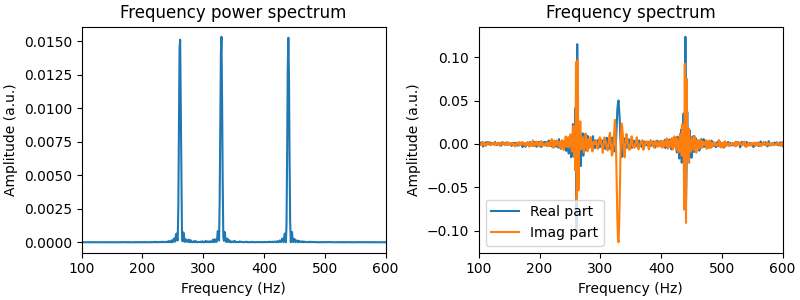

In [15]:
show_spectrum(t, sound, in_DB=False)

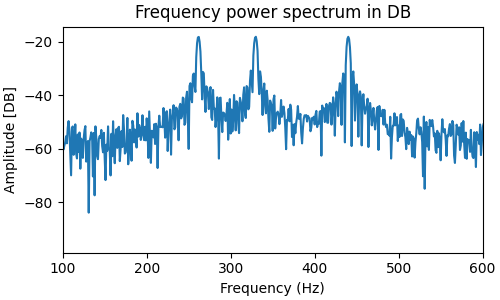

In [16]:
show_spectrum(t, sound, in_DB=True)

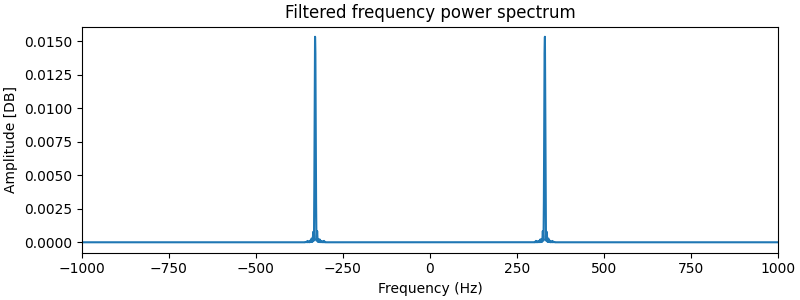

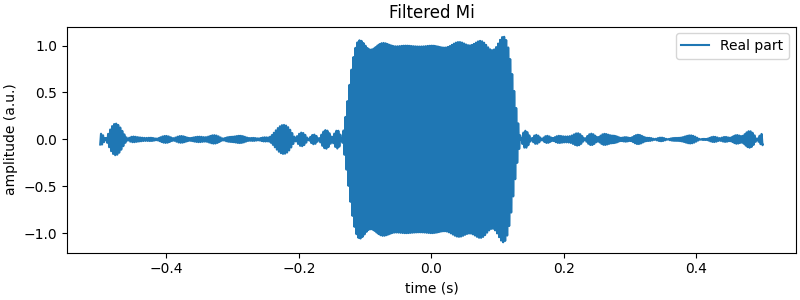

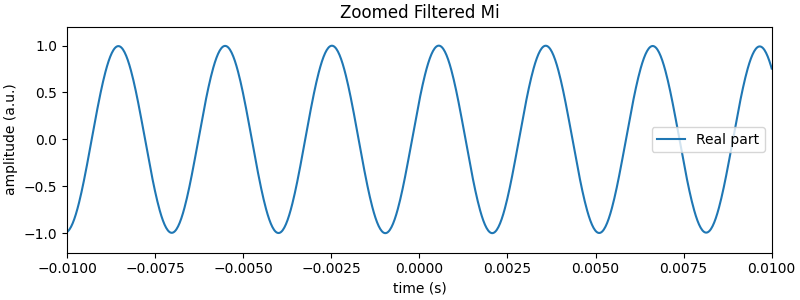

In [18]:
show_filtered_Mi(t, sound, True)

# Q2 - function crossings

In [19]:
n1 = 1.5
n2 = 1.47 
n3 = 1.45
d = 6e-6
wl = 1.55e-6 
k0 = 2 * np.pi / wl
k0d = k0*d

def LHS(kd):
    return np.tan(kd)

def RHS(kd):
    sqrt1 = np.sqrt((n1**2 - n2**2)*k0d**2 - kd**2)
    sqrt2 = np.sqrt((n1**2 - n3**2) * k0d**2 -kd**2)
    numerator = kd * (sqrt1 + sqrt2)
    denumerator = kd**2 - sqrt1*sqrt2
    return numerator / denumerator

print(f'{k0d=}, {k0d * np.sqrt(n1 ** 2 - n2 ** 2)=}')

k0d=24.322007640695173, k0d * np.sqrt(n1 ** 2 - n2 ** 2)=7.260027614310883


## A - plot both sides

The question asked to show only the range up to $k0d\sqrt{{n^2}_1 - {n^2}_2}$, since for larger values the sqrt would become imaginary. 

C:\Users\owner\AppData\Local\Temp\ipykernel_25672\2064863256.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)


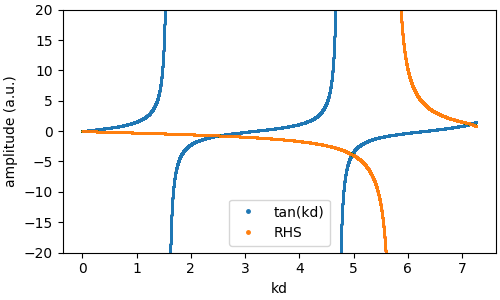

In [20]:
kds = np.linspace(0, k0d * np.sqrt(n1**2 - n2**2) - 1e-8, int(1e6))

fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
ax.plot(kds, LHS(kds), '.', markersize=0.1, label='tan(kd)')
ax.plot(kds, RHS(kds), '.', markersize=0.1, label='RHS')
ax.set_ylim([-20, 20])
ax.set_xlabel('kd')
ax.set_ylabel('amplitude (a.u.)')
ax.legend(markerscale=50)

## B - find intersection with fsolve

We find and plot the intersections using fsolve: 

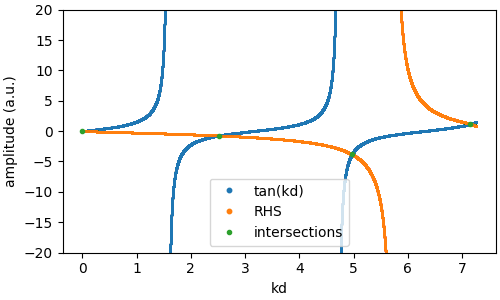

In [21]:
def diff_func(kd):
    return LHS(kd) - RHS(kd)
    
from scipy.optimize import fsolve
kds = np.linspace(0, k0d * np.sqrt(n1**2 - n2**2) - 1e-8, int(1e6))
sols = fsolve(diff_func, x0=(0, 2.5, 5, 7.2))

def plot_sols(sols):
    fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
    l_line, = ax.plot(kds, LHS(kds), '.', markersize=0.1, label='tan(kd)')
    r_line, = ax.plot(kds, RHS(kds), '.', markersize=0.1, label='RHS')
    inters_line, = ax.plot(sols, LHS(sols), '.', label='intersections')
    ax.set_ylim([-20, 20])
    ax.set_xlabel('kd')
    ax.set_ylabel('amplitude (a.u.)')
    
    # LOL I worked hard for this nice legend. Lucky to have Claude :) 
    from matplotlib.legend_handler import HandlerLine2D
    class CustomHandlerLine2D(HandlerLine2D):
        def __init__(self, markerscale=1, *args, **kwargs):
            self.markerscale = markerscale
            super().__init__(*args, **kwargs)
            
        def create_artists(self, *args, **kwargs):
            artists = super().create_artists(*args, **kwargs)
            for artist in artists:
                if hasattr(artist, 'set_markersize'):
                    artist.set_markersize(artist.get_markersize() * self.markerscale)
            return artists
    
    plt.legend([l_line, r_line, inters_line], ['tan(kd)', 'RHS', 'intersections'],
              handler_map={
                  l_line: CustomHandlerLine2D(markerscale=8, numpoints=1),
                  r_line: CustomHandlerLine2D(markerscale=8, numpoints=1),
                  inters_line: CustomHandlerLine2D(markerscale=1, numpoints=1)
              })

plot_sols(sols)

## C - find intersections manually 

I first plot the difference function to get a sense of how it looks, and then find the solutions manually by checking when it passes between positive and negative values. I take special care to avoid fake solution that might occur next to asymptotes. 

Text(0.5, 1.0, 'Difference between function')

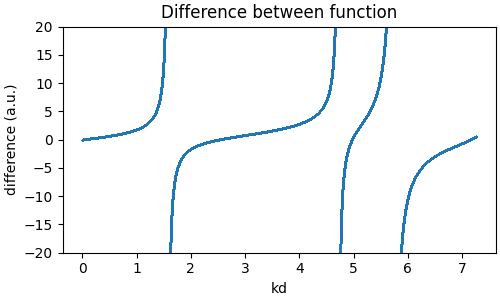

In [22]:
def diff_func(kd):
    return LHS(kd) - RHS(kd)
    
kds = np.linspace(0, k0d * np.sqrt(n1**2 - n2**2) - 1e-8, int(1e6))

fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
ax.plot(kds, diff_func(kds), '.', markersize=0.05)
ax.set_xlabel('kd')
ax.set_ylabel('difference (a.u.)')
ax.set_ylim([-20, 20])
ax.set_title('Difference between function')

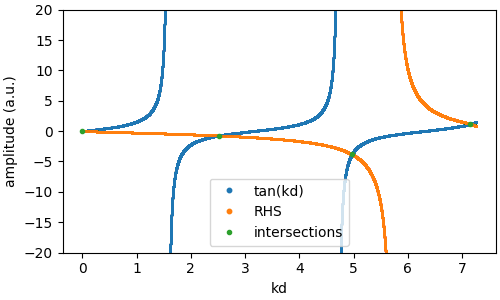

In [23]:
inters_indexes = np.where(np.diff(np.sign(diff_func(kds))) != 0)
sols = kds[inters_indexes]

# Asymptotes cause fake solutions when the numerics go between plus and minus infinity 
fake_sols = np.array([np.pi/2, 2*np.pi/2, 3*np.pi/2, 5.732])

good_sols = []
for sol in sols:
    if np.min(np.abs(sol-fake_sols)) < 0.01:
        continue
    else:
        good_sols.append(sol)

plot_sols(np.array(good_sols))